# Анализ данных кандидатов на получение кредитов

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize

In [2]:
from google.colab import drive
drive.mount('/content/drive')
borrowers = pd.read_csv('/content/drive/MyDrive/data/borrowers.csv', sep=';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Предобработка данных

In [3]:
borrowers.shape

(21525, 12)

In [4]:
borrowers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
borrowers.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [6]:
nan_count = borrowers[borrowers['days_employed'].isna() & borrowers['total_income'].isna()].shape[0]
nan_count

2174

Заполненим медианными значениями столбцов days_employed и total_income


In [7]:
for i in borrowers['income_type'].unique():
    mean_ = borrowers[borrowers['income_type'] == i]['total_income'].mean(skipna=True)
    borrowers.loc[borrowers['total_income'].isna(), 'total_income'] = mean_

In [8]:
for i in borrowers['income_type'].unique():
    mean_ = borrowers[borrowers['income_type'] == i]['days_employed'].mean(skipna=True)
    borrowers.loc[borrowers['days_employed'].isna(), 'days_employed'] = mean_

In [9]:
borrowers.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Удаление дубликатов

In [10]:
borrowers.drop_duplicates(inplace=True)

In [11]:
borrowers = borrowers.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

In [12]:
borrowers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21471 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21471 non-null  int64  
 1   days_employed     21471 non-null  float64
 2   dob_years         21471 non-null  int64  
 3   education         21471 non-null  object 
 4   education_id      21471 non-null  int64  
 5   family_status     21471 non-null  object 
 6   family_status_id  21471 non-null  int64  
 7   gender            21471 non-null  object 
 8   income_type       21471 non-null  object 
 9   debt              21471 non-null  int64  
 10  total_income      21471 non-null  float64
 11  purpose           21471 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


## Разведочный анализ данных

### Проверка аномалий

In [13]:
borrowers['children'].describe()

count    21471.000000
mean         0.539565
std          1.382978
min         -1.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64

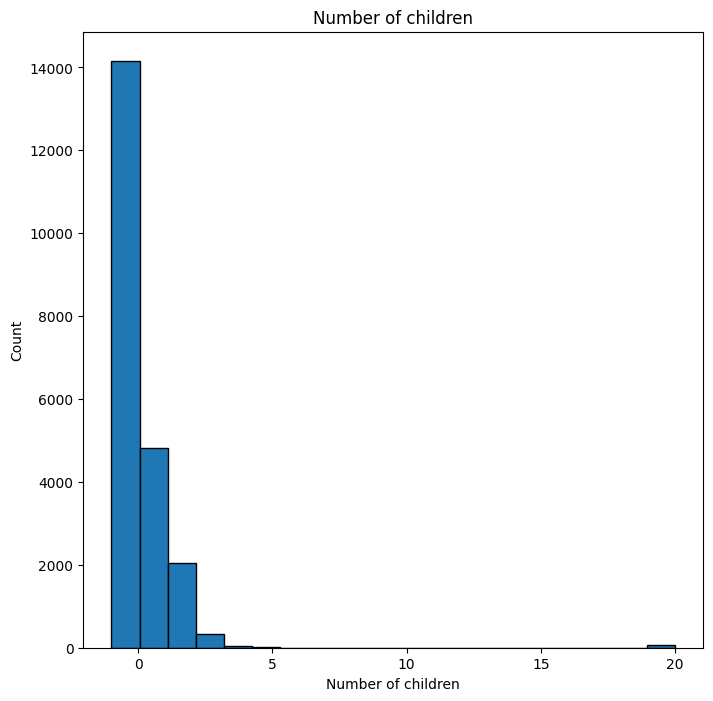

In [14]:
figsize(8, 8)

plt.hist(borrowers['children'], bins = 20, edgecolor = 'k')

plt.xlabel('Number of children')
plt.ylabel('Count')
plt.title('Number of children')
plt.show()

Явно видно, что есть несколько выбросов:
- отрицательное количество детей,
- слишком большое количество детей (20)


Ограничим количество детей снизу 0.

In [15]:
borrowers = borrowers[borrowers['children'] >= 0.0]
borrowers['children'].describe()

count    21424.000000
mean         0.542942
std          1.382611
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64

In [16]:
(borrowers['children'] == 20.0).sum()

76

Как мы видим, встерчается 76 раз семья с 20-ю детьми, однако семей с числом детей между 5 и 20 нет, что маловероятно с точки зрения нормального распределения (6-19 детей вероятнее чем 20, т.к. 20 лежат дальше от медианного значения). Следовательно можем считать 20 детей аномалией.

Рассмотрим распределение количества детей с помощью box-plot:

<Axes: ylabel='children'>

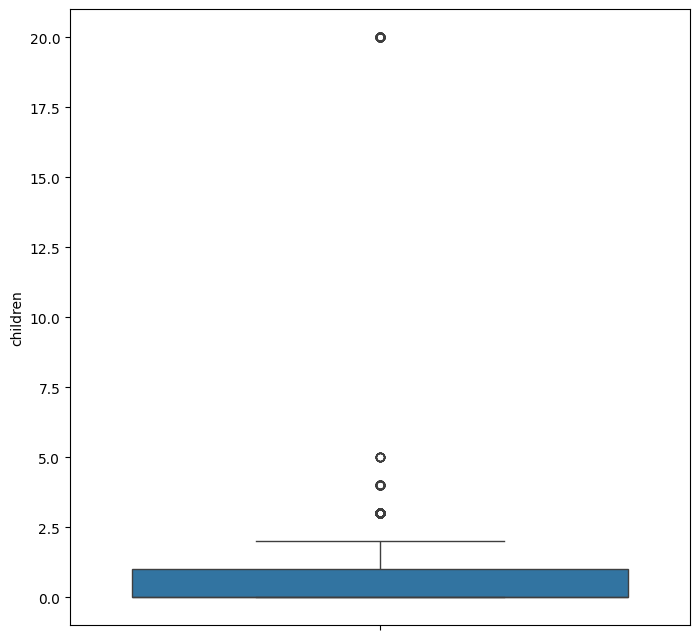

In [17]:
sns.boxplot(borrowers['children'])

Теперь нет необходимости ограничивать данные снизу (сделано уже семнатически), остается ограничить их сверху.

In [18]:
factor = 4
upper_lim = borrowers['children'].mean() + borrowers['children'].std() * factor
borrowers = borrowers[(borrowers['children'] < upper_lim)]

In [19]:
borrowers['children'].describe()

count    21348.000000
mean         0.473674
std          0.752199
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: children, dtype: float64

<Axes: ylabel='children'>

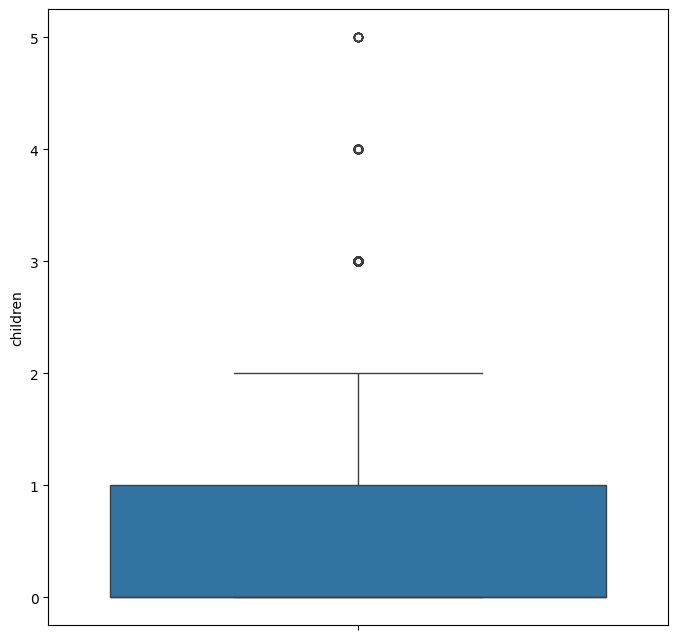

In [20]:
sns.boxplot(borrowers['children'])

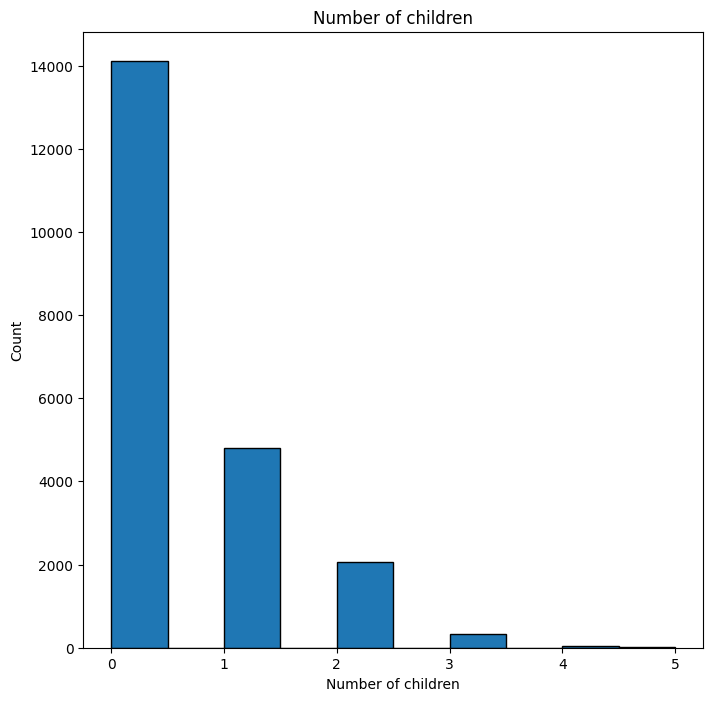

In [21]:
figsize(8, 8)

plt.hist(borrowers['children'], bins = 10, edgecolor = 'k')

plt.xlabel('Number of children')
plt.ylabel('Count')
plt.title('Number of children')
plt.show()

In [22]:
borrowers['days_employed'].describe()

count     21348.000000
mean      56693.399447
std      135208.642840
min      -18388.949901
25%       -2520.949441
50%       -1460.639646
75%        -382.382404
max      401755.400475
Name: days_employed, dtype: float64

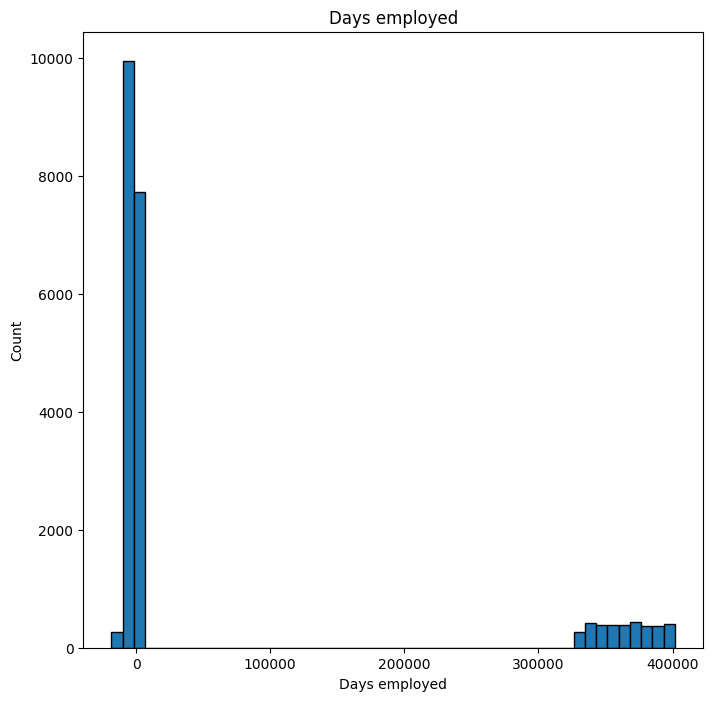

In [23]:
figsize(8, 8)

plt.hist(borrowers['days_employed'], bins = 50, edgecolor = 'k')

plt.xlabel('Days employed')
plt.ylabel('Count')
plt.title('Days employed')
plt.show()

Явно видны аномалии:
- медианное количество рабочих дней - 56780 (~156 лет)
- минимальное количество рабочих дней отрицательно (семантический бред)
- максимальное количество рабочих дней - 401755 (~1100 лет)
- большой разрыв, нарушающий нормальное распределение и не обусловленный семантически

Данных в промежутке от 0 до более чем 300000 дней нет, из чего можно заключить, что данные в этой колонке критически не используемы и данная колонка должна быть удалена.

In [24]:
borrowers = borrowers.drop('days_employed', axis=1)

In [25]:
borrowers['total_income'].describe()

count    2.134800e+04
mean     1.668496e+05
std      9.789879e+04
min      2.066726e+04
25%      1.075597e+05
50%      1.561616e+05
75%      1.957838e+05
max      2.265604e+06
Name: total_income, dtype: float64

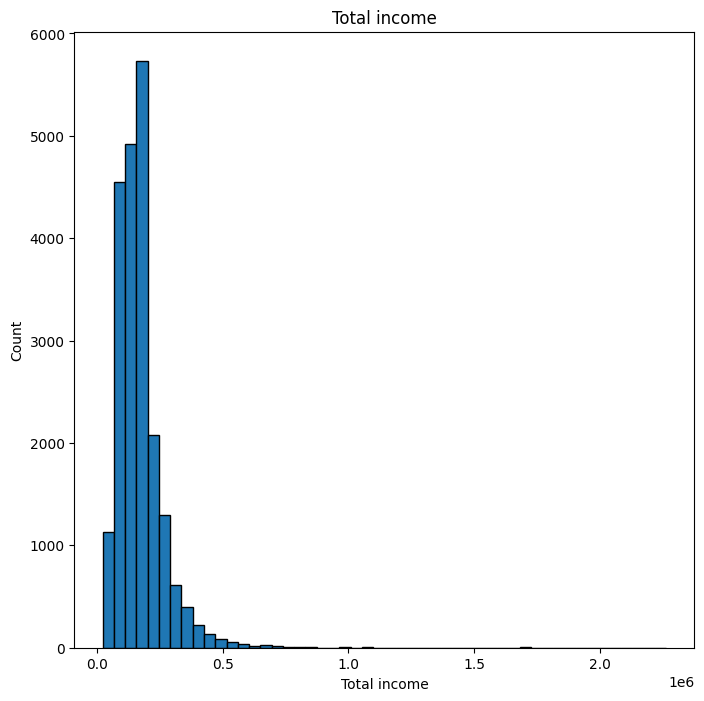

In [26]:
figsize(8, 8)

plt.hist(borrowers['total_income'], bins = 50, edgecolor = 'k')

plt.xlabel('Total income')
plt.ylabel('Count')
plt.title('Total income')
plt.show()

Данные столбца Total income не выглядят подозрительными

Остальные столбцы представляют собой нечисловые признаки.

## Категоризация

In [27]:
def categorize_income(total_income):
    if total_income <= 30000:
        return '0'
    elif 30001 <= total_income <= 50000:
        return '1'
    elif 50001 <= total_income <= 200000:
        return '2'
    elif 200001 <= total_income <= 1000000:
        return '3'
    else:
        return '4'

In [28]:
borrowers['total_income_category'] = borrowers['total_income'].apply(categorize_income)
borrowers['total_income_category'] = borrowers['total_income'].astype(int)

In [29]:
borrowers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21348 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   children               21348 non-null  int64  
 1   dob_years              21348 non-null  int64  
 2   education              21348 non-null  object 
 3   education_id           21348 non-null  int64  
 4   family_status          21348 non-null  object 
 5   family_status_id       21348 non-null  int64  
 6   gender                 21348 non-null  object 
 7   income_type            21348 non-null  object 
 8   debt                   21348 non-null  int64  
 9   total_income           21348 non-null  float64
 10  purpose                21348 non-null  object 
 11  total_income_category  21348 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 2.1+ MB


In [30]:
def categorize_purpose(purpose):
    if 'авто' in purpose.lower():
        return '0'
    elif 'недвижим' in purpose.lower() or 'жиль' in purpose.lower():
        return '1'
    elif 'свадьб' in purpose.lower():
        return '2'
    elif 'образован' in purpose.lower():
        return '3'


In [31]:
borrowers['purpose_category'] = borrowers['purpose'].apply(categorize_purpose)
borrowers['purpose_category'] = borrowers['purpose_category'].astype(int)

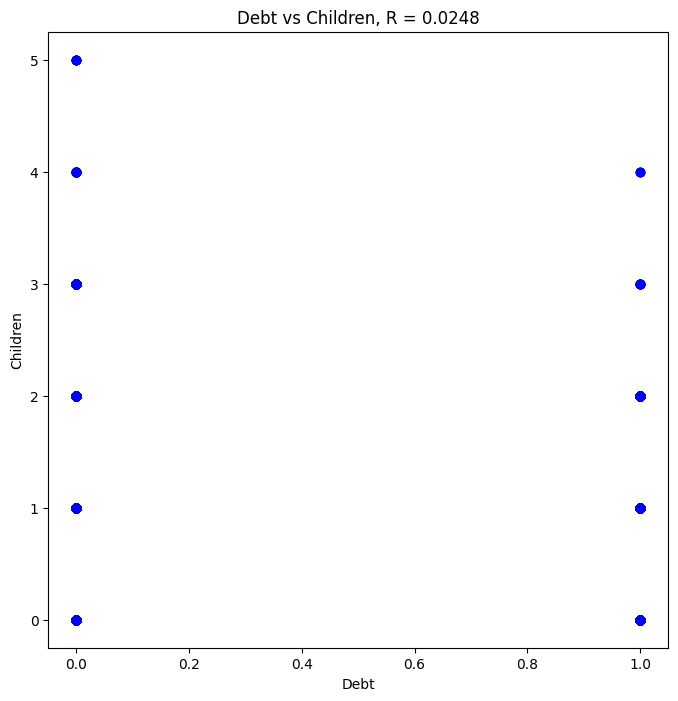

In [32]:
plot_data = borrowers[['debt', 'children']]

plt.plot(plot_data['debt'], plot_data['children'], 'bo')
plt.xlabel('Debt')
plt.ylabel('Children')
plt.title('Debt vs Children, R = %0.4f' % np.corrcoef(borrowers[['debt', 'children']], rowvar=False)[0][1])
plt.show()

Вывод 1:

Нет зависимости между возникновением задолженности и количеством детей.

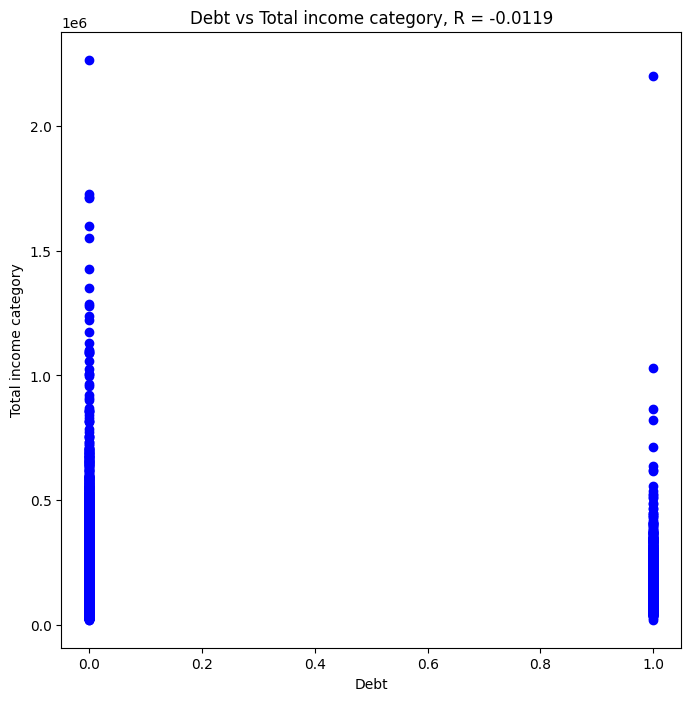

In [33]:
plot_data = borrowers[['debt', 'total_income_category']]

plt.plot(plot_data['debt'], plot_data['total_income_category'], 'bo')
plt.xlabel('Debt')
plt.ylabel('Total income category')
plt.title('Debt vs Total income category, R = %0.4f' % np.corrcoef(borrowers[['debt', 'total_income_category']], rowvar=False)[0][1])
plt.show()

Вывод 2:

Нет зависимости между возникновением задолженности и уровнем дохода.

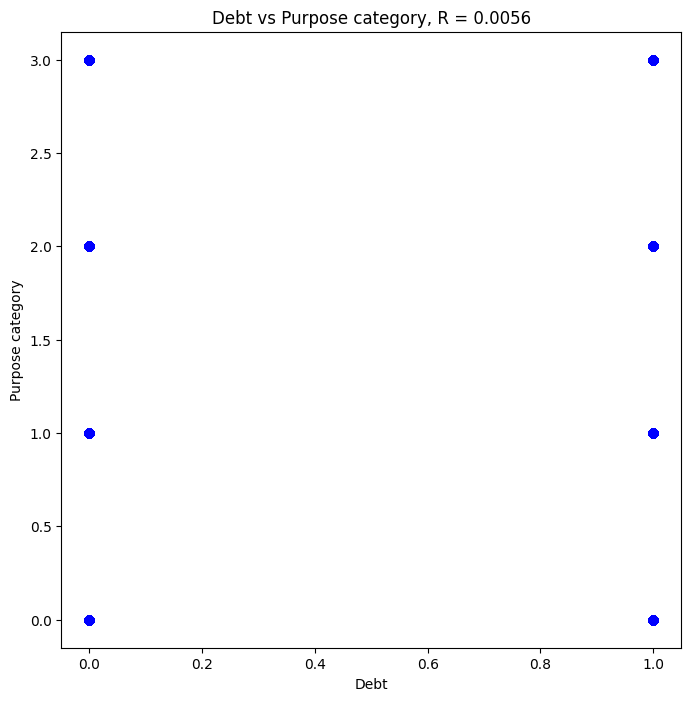

In [34]:
plot_data = borrowers[['debt', 'purpose_category']]

plt.plot(plot_data['debt'], plot_data['purpose_category'], 'bo')
plt.xlabel('Debt')
plt.ylabel('Purpose category')
plt.title('Debt vs Purpose category, R = %0.4f' % np.corrcoef(borrowers[['debt', 'purpose_category']], rowvar=False)[0][1])
plt.show()

Вывод 3:

Нет зависимости между возникновением задолженности и целью кредитования.

In [36]:
borrowers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21348 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   children               21348 non-null  int64  
 1   dob_years              21348 non-null  int64  
 2   education              21348 non-null  object 
 3   education_id           21348 non-null  int64  
 4   family_status          21348 non-null  object 
 5   family_status_id       21348 non-null  int64  
 6   gender                 21348 non-null  object 
 7   income_type            21348 non-null  object 
 8   debt                   21348 non-null  int64  
 9   total_income           21348 non-null  float64
 10  purpose                21348 non-null  object 
 11  total_income_category  21348 non-null  int64  
 12  purpose_category       21348 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [ ]:
borrowers['purpose_category'].count_values